[Panel2] RMS(ν1)=91.5s  RMS(ν2)=137.2s  delta=-193.36s


C:\Users\pc\AppData\Local\Temp\ipykernel_3804\2011192271.py:303: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


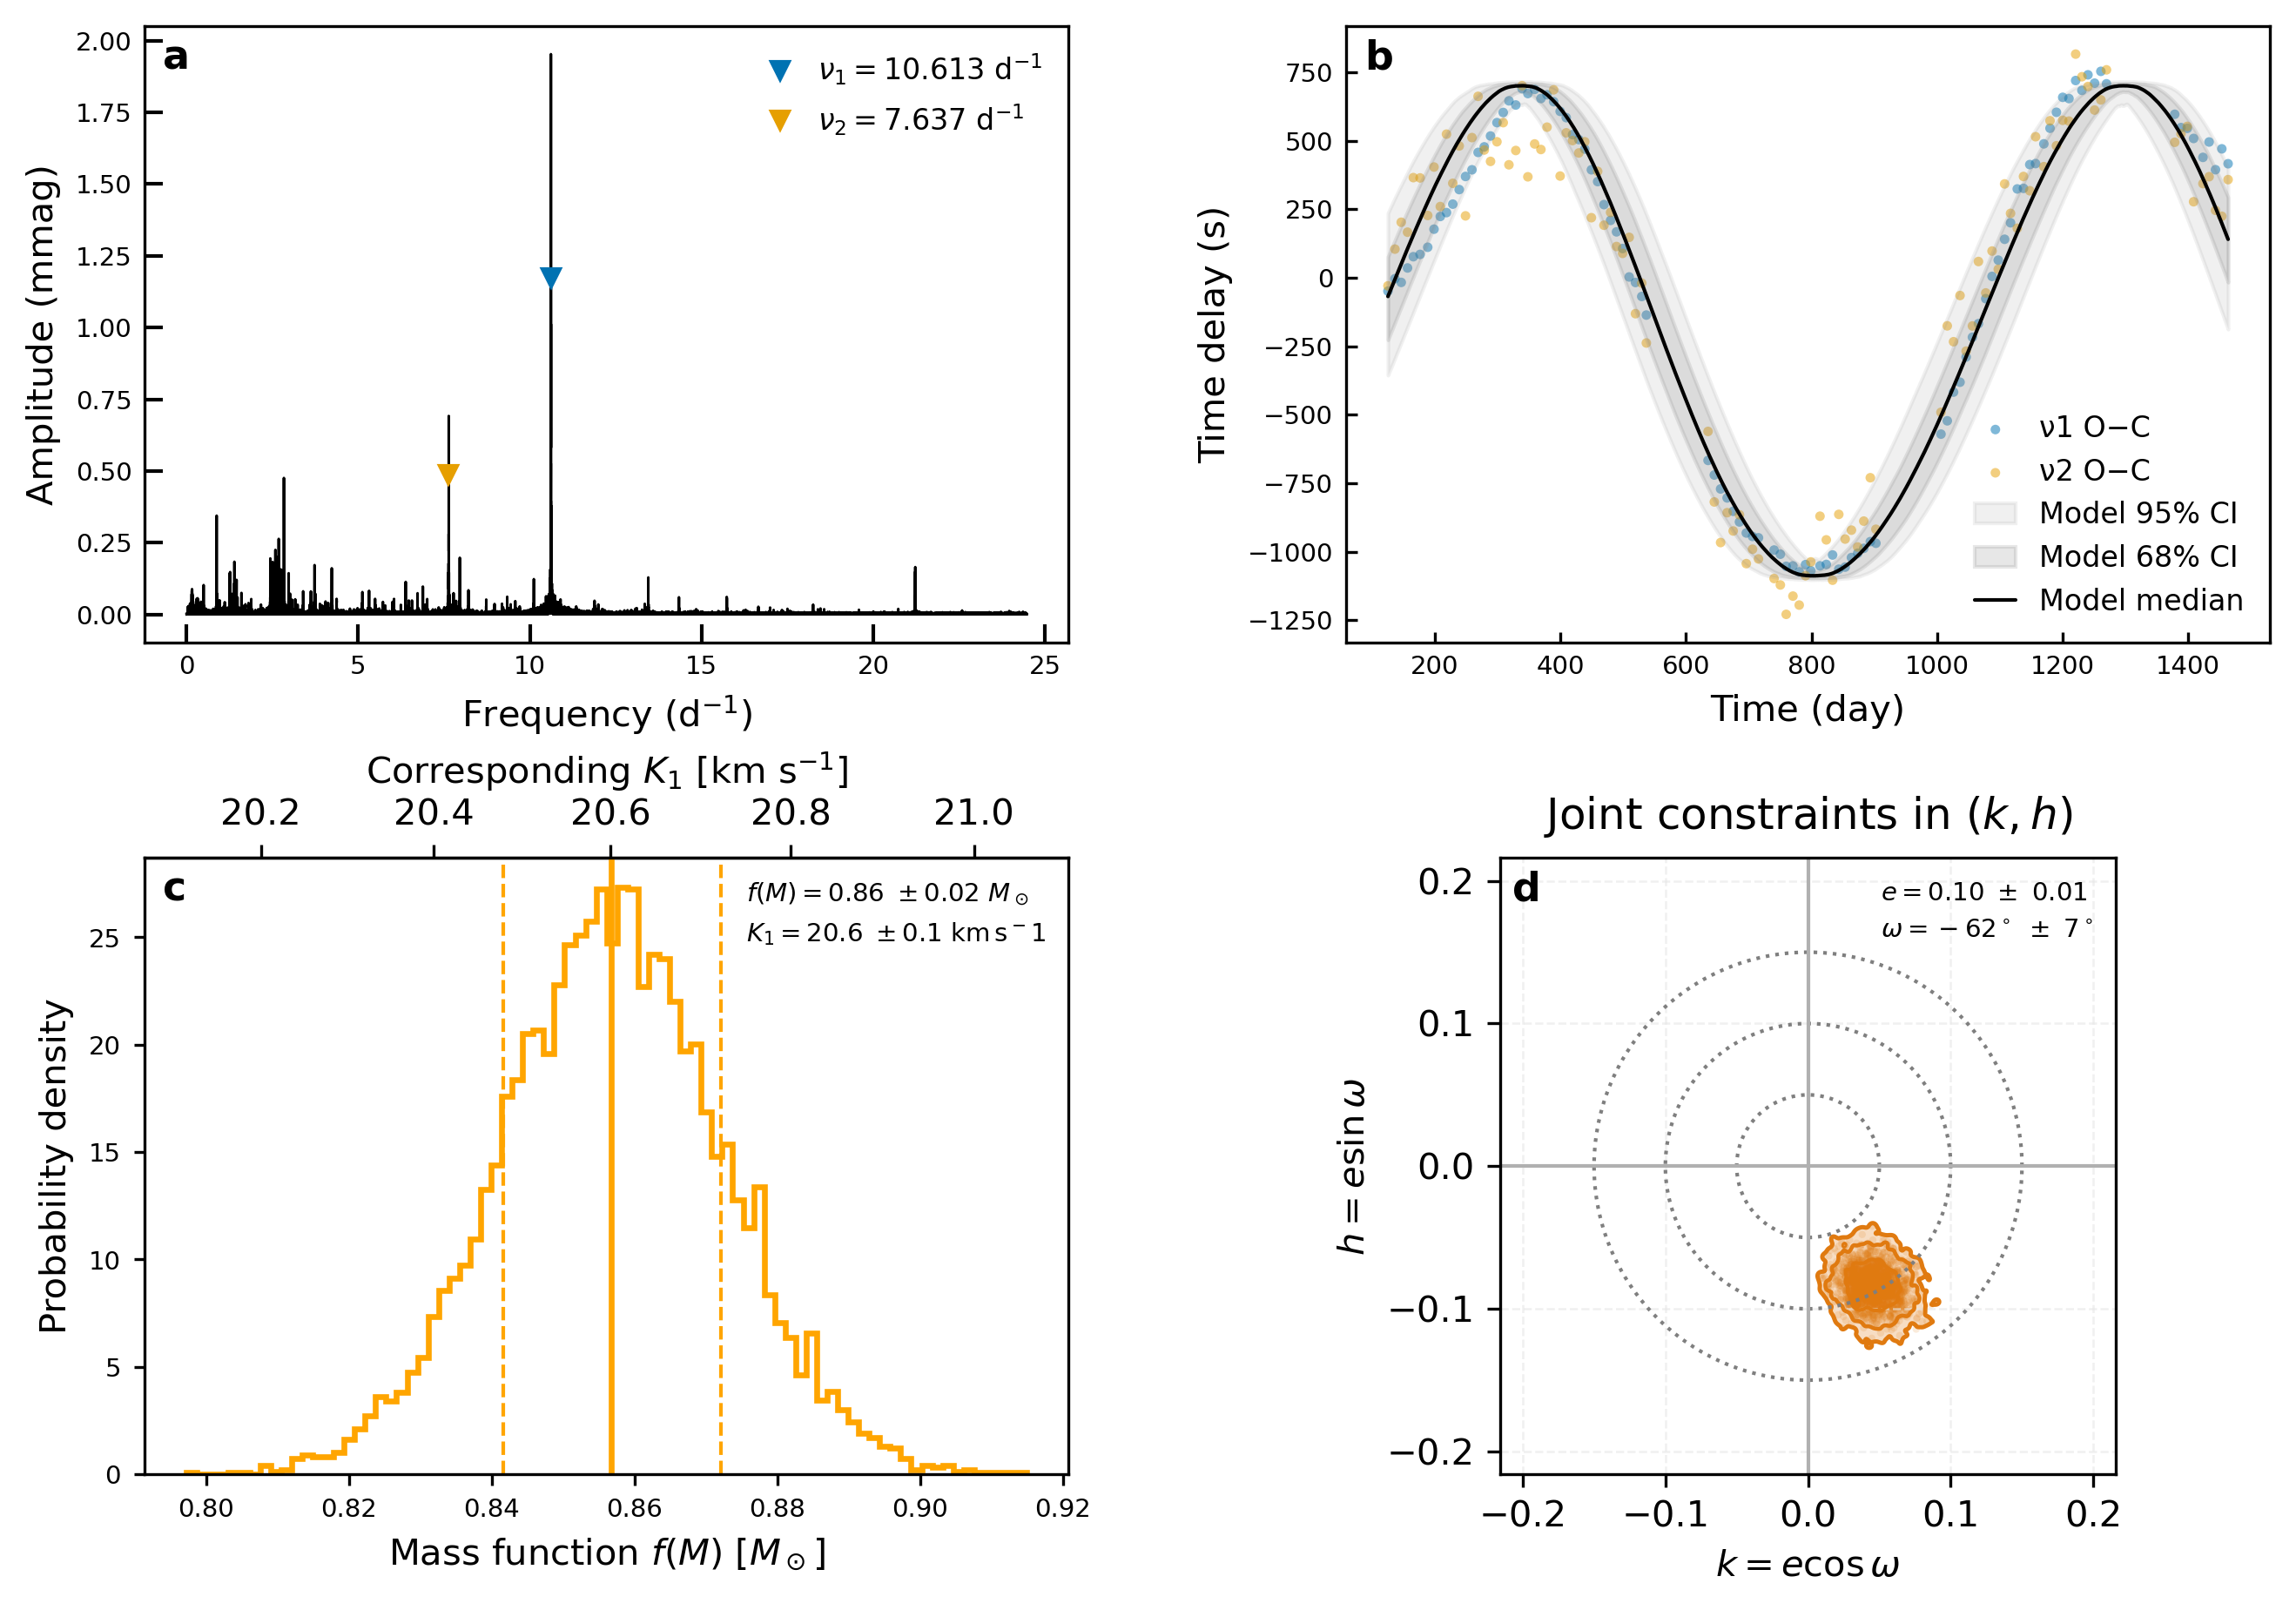

Saved: figure1.png


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
figure_four_panels.py

Inputs (text files):
  1) fft.fou          : two columns -> freq[d^-1], power (or amplitude)
  2) tdt.txt          : 1-D array of time midpoints [days] for PM segments
  3) tdd.txt          : 2-D array with two columns -> O-C time delays [s] for ν1 and ν2
  4) PB1_arrays.txt   : 5 arrays (shape (5,N) or (N,5)) -> P[days], e, a1sini[sec], omega[rad], phi[rad]

Output:
  - figure1.png       : 2x2 panel figure

Dependencies: numpy, matplotlib
"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.lines import Line2D

# ----- style -----
LABEL_FS   = 10
TICK_MAJ_L = 3
TICK_MIN_L = 2
TICK_W     = 0.8
LEG_FS_TOP = 8
LEG_FS_BOT = 7

NU1 = 10.613450  # d^-1
NU2 =  7.637468  # d^-1

# ----- load inputs -----
def load_fft(path="fft.fou"):
    arr = np.loadtxt(path)
    if arr.ndim != 2 or arr.shape[1] < 2:
        raise ValueError(f"[fft] Expect 2 columns (freq, power), got shape: {arr.shape}")
    return arr[:,0], arr[:,1]

def load_time_delay_xy(t_path="tdt.txt", y_path="tdd.txt"):
    t = np.loadtxt(t_path)
    y = np.loadtxt(y_path)
    t = np.asarray(t, dtype=float).ravel()
    y = np.asarray(y, dtype=float)
    if y.ndim != 2 or y.shape[1] < 2:
        raise ValueError(f"[tdd] Expect 2 columns (nu1, nu2), got shape: {y.shape}")
    if t.size != y.shape[0]:
        raise ValueError(f"[tdt/tdd] Length mismatch: len(time)={t.size} vs rows(y)={y.shape[0]}")
    return t, y[:,0], y[:,1]

def load_pb1(path="PB1_arrays.txt"):
    data = np.loadtxt(path)
    if data.ndim != 2:
        raise ValueError(f"[PB1] Need 2-D array, got {data.ndim}-D {data.shape}")
    if data.shape[0] == 5:
        P, e, a1sini, om, phi = data
    elif data.shape[1] == 5:
        P, e, a1sini, om, phi = data.T
    else:
        raise ValueError(f"[PB1] Expect shape (5,N) or (N,5), got {data.shape}")
    return map(np.asarray, (P, e, a1sini, om, phi))

# ----- math helpers -----
def solve_kepler_E(M, e, tol=1e-12, maxiter=128):
    M = (np.asarray(M) + np.pi) % (2*np.pi) - np.pi
    E = M.copy()
    for _ in range(maxiter):
        dE = (E - e*np.sin(E) - M) / (1 - e*np.cos(E))
        E -= dE
        if np.max(np.abs(dE)) < tol:
            break
    return E

def tau_sec_from_params(tin, P, asini, e, omega, phi):
    M = 2.0*np.pi * tin / P - phi
    E = solve_kepler_E(M, e)
    fac   = np.sqrt((1+e)/(1-e))
    ftrue = 2*np.arctan2(fac*np.sin(E/2.0), np.cos(E/2.0))
    psi   = -(1 - e**2) * np.sin(ftrue + omega) / (1 + e*np.cos(ftrue))
    return asini * psi

def rms(x):
    x = np.asarray(x)
    return np.sqrt(np.nanmean(x**2))

# ----- panels -----
def plot_panel1(ax, freq, power, mmag_scale=True):
    amp = power * (1000.0 if mmag_scale else 1.0)
    col1, col2 = "#0072B2", "#E69F00"
    ax.plot(freq, amp, color='black', linewidth=0.7)
    ax.set_xlabel("Frequency (d$^{-1}$)", fontsize=LABEL_FS)
    ax.set_ylabel("Amplitude (mmag)" if mmag_scale else "Amplitude", fontsize=LABEL_FS)
    ax.tick_params(axis='both', which='major', labelsize=LABEL_FS-3,
                   length=TICK_MAJ_L, width=TICK_W)
    ax.tick_params(axis='both', which='minor', labelsize=LABEL_FS-3,
                   length=TICK_MIN_L, width=TICK_W-0.2)
    ax.tick_params(direction='in', length=5, width=1, which='both')

    ax.plot(NU1, np.nanmax(amp)*0.60, marker='v', ms=5, mfc=col1, mec=col1, ls='',
            zorder=3, clip_on=False, label=rf"$\nu_1={NU1:.3f}\ \mathrm{{d}}^{{-1}}$")
    ax.plot(NU2, np.nanmax(amp)*0.25, marker='v', ms=5, mfc=col2, mec=col2, ls='',
            zorder=3, clip_on=False, label=rf"$\nu_2={NU2:.3f}\ \mathrm{{d}}^{{-1}}$")
    ax.legend(loc='upper right', frameon=False, handlelength=1.0,
              markerscale=1.0, fontsize=LEG_FS_TOP)

def plot_panel2(ax, t, y1, y2):
    # replace with your posterior summaries if needed
    P_mu,   P_sd   = 960.137, 2.072
    as_mu,  as_sd  = 902.695, 5.169
    e_mu,   e_sd   = 0.096,   0.013
    om_mu,  om_sd  = -1.077,  0.122
    phi_mu, phi_sd = 2.663,   0.119

    rng = np.random.default_rng(42)
    N = 800
    P_s   = rng.normal(P_mu,   P_sd,  size=N)
    as_s  = rng.normal(as_mu,  as_sd, size=N)
    e_s   = rng.normal(e_mu,   e_sd,  size=N)
    om_s  = rng.normal(om_mu,  om_sd, size=N)
    phi_s = rng.normal(phi_mu, phi_sd, size=N)

    P_s   = np.maximum(P_s, 1e-3)
    as_s  = np.maximum(as_s, 1e-6)
    e_s   = np.clip(e_s, 1e-6, 0.999)
    wrap  = lambda x: (x + np.pi) % (2*np.pi) - np.pi
    om_s  = wrap(om_s)
    phi_s = wrap(phi_s)

    t_min, t_max = np.nanmin(t), np.nanmax(t)
    td = np.linspace(t_min, t_max, 2000)

    tau_draws = np.empty((N, td.size), dtype=float)
    for j in range(N):
        tau_j = tau_sec_from_params(td, P_s[j], as_s[j], e_s[j], om_s[j], phi_s[j])
        shift_j = as_s[j] * e_s[j] * np.sin(om_s[j])
        tau_draws[j] = tau_j - shift_j

    q2, q16, q50, q84, q97 = np.percentile(tau_draws, [2.5, 16, 50, 84, 97.5], axis=0)

    q50_at_t = np.interp(t, td, q50)
    delta = np.nanmedian(np.concatenate([y1 - q50_at_t, y2 - q50_at_t]))
    q2 += delta; q16 += delta; q50 += delta; q84 += delta; q97 += delta

    RMS_v1 = rms(y1 - np.interp(t, td, q50))
    RMS_v2 = rms(y2 - np.interp(t, td, q50))
    print(f"[Panel2] RMS(ν1)={RMS_v1:.1f}s  RMS(ν2)={RMS_v2:.1f}s  delta={delta:.2f}s")

    COL_NU1, COL_NU2, COL_MODEL, COL_BAND = "#0072B2", "#E69F00", "#000000", "#888888"
    ax.scatter(t, y1, s=7, c=COL_NU1, alpha=0.50, edgecolors='none', label='ν1 O−C', zorder=0, rasterized=True)
    ax.scatter(t, y2, s=7, c=COL_NU2, alpha=0.50, edgecolors='none', label='ν2 O−C', zorder=0, rasterized=True)
    ax.fill_between(td, q2,  q97, color=COL_BAND, alpha=0.12, label='Model 95% CI', zorder=1)
    ax.fill_between(td, q16, q84, color=COL_BAND, alpha=0.20, label='Model 68% CI', zorder=2)
    ax.plot(td, q50, color=COL_MODEL, linewidth=1.0, solid_capstyle='round', label='Model median', zorder=3)

    ax.set_xlabel("Time (day)", fontsize=LABEL_FS)
    ax.set_ylabel("Time delay (s)", fontsize=LABEL_FS)
    ax.tick_params(direction='in', length=TICK_MAJ_L, width=1, which='both')
    ax.tick_params(axis='both', which='major', labelsize=LABEL_FS-3, length=TICK_MAJ_L, width=TICK_W)
    ax.tick_params(axis='both', which='minor', labelsize=LABEL_FS-3, length=TICK_MIN_L, width=TICK_W-0.2)
    ax.legend(loc='lower right', frameon=False, handlelength=1.4, fontsize=LEG_FS_TOP)

def plot_panel3(ax, P, e, a1sini):
    G = 6.67430e-11
    M_sun = 1.98847e30
    c = 299792458.0
    day = 86400.0

    P_arr  = np.asarray(P, float)
    e_arr  = np.asarray(e, float)
    asi_arr= np.asarray(a1sini, float)
    msk = np.isfinite(P_arr) & np.isfinite(e_arr) & np.isfinite(asi_arr) & (P_arr > 0) & (asi_arr > 0)
    P_arr, e_arr, asi_arr = P_arr[msk], e_arr[msk], asi_arr[msk]

    a1si = c * asi_arr
    K1   = (2*np.pi*a1si) / (P_arr*day*np.sqrt(1 - e_arr**2))      # m/s
    K1_km = K1 / 1e3

    fM   = (K1**3 * (P_arr*day) / (2*np.pi*G)) * (1 - e_arr**2)**(3/2) / M_sun

    med_fM = np.median(fM); lo_fM, hi_fM = np.percentile(fM, [16, 84])
    med_K1 = np.median(K1_km); lo_K1, hi_K1 = np.percentile(K1_km, [16, 84])

    ax.hist(fM, bins=80, histtype='step', linewidth=1.6, color='orange', density=True)
    ax.axvline(med_fM, color='orange', lw=1.6)
    ax.axvline(lo_fM,  color='orange', lw=1.0, ls='--')
    ax.axvline(hi_fM,  color='orange', lw=1.0, ls='--')

    ax.set_xlabel(r"Mass function $f(M)$ [$M_\odot$]", fontsize=LABEL_FS)
    ax.set_ylabel("Probability density", fontsize=LABEL_FS)
    ax.tick_params(axis='both', which='major', labelsize=LABEL_FS-3, length=TICK_MAJ_L, width=TICK_W)
    ax.tick_params(axis='both', which='minor', labelsize=LABEL_FS-3, length=TICK_MIN_L, width=TICK_W-0.2)
    ax.grid(False)

    Aphys = ((2*np.pi*G*M_sun)/(np.median(P_arr)*day))**(1/3) / np.sqrt(1 - np.median(e_arr)**2) / 1e3
    dx = 9e-4
    def fM_to_K1_shifted(x): return Aphys * np.power(x + dx, 1/3)
    def K1_to_fM_shifted(k): return np.power(k / Aphys, 3) - dx
    ax_top = ax.secondary_xaxis('top', functions=(fM_to_K1_shifted, K1_to_fM_shifted))
    ax_top.set_xlabel(r"Corresponding $K_1$ [km s$^{-1}$]", fontsize=LABEL_FS)

    err_fM = 0.5 * (hi_fM - lo_fM)
    err_K1 = 0.5 * (hi_K1 - lo_K1)
    h1 = Line2D([], [], color='none', label=rf"$f(M) = {med_fM:.2f}\ \pm {err_fM:.2f}\ M_\odot$")
    h2 = Line2D([], [], color='none', label=rf"$K_1 = {med_K1:.1f}\ \pm {err_K1:.1f}\ \rm km\,s^{-1}$")
    ax.legend(handles=[h1, h2], loc='upper right', frameon=False, handlelength=1.0, fontsize=LEG_FS_BOT)

def gaussian_kde2d(x, y, bins=240, bw=0.9, pad_ratio=0.20):
    x_min, x_max = np.percentile(x, [0.2, 99.8])
    y_min, y_max = np.percentile(y, [0.2, 99.8])
    pad = pad_ratio * max(x_max - x_min, y_max - y_min)
    x_min, x_max = x_min - pad, x_max + pad
    y_min, y_max = y_min - pad, y_max + pad
    H, xedges, yedges = np.histogram2d(x, y, bins=bins, range=[[x_min, x_max], [y_min, y_max]])
    gx = np.linspace(-3, 3, 31)
    G  = np.exp(-0.5 * (gx / bw)**2)
    G  = np.outer(G, G); G /= G.sum()
    pad_x, pad_y = G.shape[0]//2, G.shape[1]//2
    Hp = np.pad(H, ((pad_x, pad_x), (pad_y, pad_y)), mode='constant')
    F  = np.fft.rfft2(Hp)
    Gp = np.zeros_like(Hp); Gp[:G.shape[0], :G.shape[1]] = G
    Gp = np.roll(np.roll(Gp, -pad_x, axis=0), -pad_y, axis=1)
    Z  = np.fft.irfft2(F * np.fft.rfft2(Gp), s=Hp.shape)
    Z  = Z[pad_x:-pad_x, pad_y:-pad_y]
    xcent = 0.5 * (xedges[:-1] + xedges[1:])
    ycent = 0.5 * (yedges[:-1] + yedges[1:])
    return xcent, ycent, Z.T

def hpd_levels(dens, qs=(0.68, 0.95, 0.997)):
    d = dens.ravel()
    idx = np.argsort(d)[::-1]
    c = np.cumsum(d[idx]); c /= c[-1]
    thr = [d[idx[np.searchsorted(c, q)]] for q in qs]
    return sorted(thr)

def plot_panel4(ax, e_arr, om_arr):
    e_arr   = np.asarray(e_arr,  dtype=float)
    om_arr  = np.asarray(om_arr, dtype=float)
    msk = np.isfinite(e_arr) & np.isfinite(om_arr) & (e_arr >= 0)
    e_arr, om_arr = e_arr[msk], om_arr[msk]

    k = e_arr * np.cos(om_arr)
    h = e_arr * np.sin(om_arr)

    accent = '#e07a10'
    xg, yg, Z = gaussian_kde2d(k, h, bins=240, bw=0.9, pad_ratio=0.20)
    lev = hpd_levels(Z, qs=(0.68, 0.95, 0.997))
    lev_f = np.r_[lev, Z.max()]

    ax.contourf(xg, yg, Z, levels=lev_f, colors=[accent, accent, accent], alpha=0.25, antialiased=True)
    ax.contour (xg, yg, Z, levels=lev,   colors=accent, linewidths=(1.2, 1.1, 1.0))

    n_show = min(2000, k.size)
    idx = np.random.default_rng(42).choice(k.size, n_show, replace=False)
    ax.scatter(k[idx], h[idx], s=4, ec='none', fc=accent, alpha=0.15)

    for e_ref in [0.05, 0.10, 0.15]:
        th = np.linspace(0, 2*np.pi, 400)
        ax.plot(e_ref*np.cos(th), e_ref*np.sin(th), ls=':', lw=1.0, color='#7f7f7f')

    ax.axhline(0.0, color='#b0b0b0', lw=1.0)
    ax.axvline(0.0, color='#b0b0b0', lw=1.0)

    ax.set_xlabel(r"$k = e\cos\omega$", fontsize=LABEL_FS)
    ax.set_ylabel(r"$h = e\sin\omega$", fontsize=LABEL_FS)
    ax.set_title(r"Joint constraints in $(k, h)$", pad=8, fontsize=LABEL_FS+2)

    r_data = max(np.max(np.abs(k)), np.max(np.abs(h)))
    r = max(0.16, r_data) * 1.35
    ax.set_xlim(-r, r)
    ax.set_ylim(-r, r)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, color='#e6e6e6', lw=0.6, ls='--', alpha=0.6)

    mean_e, sd_e = 0.096, 0.013
    mean_om, sd_om = -1.077, 0.122
    h1 = Line2D([], [], color='none', label=rf"$e = {mean_e:.2f}\ \pm\ {sd_e:.2f}$")
    h2 = Line2D([], [], color='none', label=rf"$\omega = {np.degrees(mean_om):.0f}^\circ\ \pm\ {np.degrees(sd_om):.0f}^\circ$")
    ax.legend(handles=[h1, h2], loc='upper right', frameon=False, handlelength=1.0, fontsize=LEG_FS_BOT)

# ----- compose figure -----
def plot_four_panels(outpath="figure1.png"):
    freq, power = load_fft("fft.fou")
    t, y1, y2   = load_time_delay_xy("tdt.txt", "tdd.txt")
    P, e, asi, om, phi = load_pb1("PB1_arrays.txt")

    fig = plt.figure(figsize=(10.5, 7.2), dpi=300)
    gs = gridspec.GridSpec(2, 2, figure=fig, hspace=0.35, wspace=0.30)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])

    for ax, lab in zip([ax1, ax2, ax3, ax4], 'abcd'):
        ax.text(0.02, 0.98, lab, transform=ax.transAxes, ha='left', va='top', fontsize=11, fontweight='bold')

    plot_panel1(ax1, freq, power, mmag_scale=True)
    plot_panel2(ax2, t, y1, y2)
    plot_panel3(ax3, P, e, asi)
    plot_panel4(ax4, e, om)

    plt.tight_layout()
    plt.savefig(outpath, dpi=600, bbox_inches='tight')
    plt.show()
    print(f"Saved: {outpath}")

# ----- run -----
if __name__ == "__main__":
    plot_four_panels("figure1.png")